In [1]:
from __future__ import division, print_function

## Evaluate deep model for sequence editing from Keras

### Obtain data and keras model
We will load a keras model and compute importance scores

#### Download the keras model
Download a model with 2 strided convolutional layers and 2 dense layers, similar to the one in the paper.

Tweaking

### Load the keras model
A user warning about compilation is generated because this model was converted from a keras 1.2 model and was thus never compiled for training.

In [185]:
import keras
saved_model_file = "/home/ubuntu/CRISPR-BE-RNA-editing/model_outputs/CBE-BE3-27April/overall_model.h5"
keras_model = keras.models.load_model(saved_model_file)
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 91, 50)            2800      
_________________________________________________________________
conv2 (Conv1D)               (None, 81, 50)            27550     
_________________________________________________________________
global_average_pooling1d_20  (None, 50)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout1 (Dropout)           (None, 50)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 3)                 153       
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 4         
__________

### Load the data

In [186]:
import gzip
import glob
import numpy as np
import random
import pandas

seqlen = 101
edit_pos = 50
#data_path = "/home/ubuntu/CRISPR-ABE-RNA-DATA/fastas/ABE-forDeepLift/156B-mid-sampled.fasta.gz"
data_path = "/home/ubuntu/CRISPR-CBE-RNA-DATA/fastas/CBE-forDeepLift/89B-mid-sampled.fasta.gz"
def read_fasta(f):
    def gen():
        for l in gzip.open(f, "r"):
            if l.startswith(b'>'):
                library, location, strand, rate, cov, anno, gene = l.split(b'_')
                name = l.strip()[1:]
            else:
                yield l.strip().decode().lower(), float(rate), name
    stack = pandas.DataFrame.from_records([v for v in gen()], columns="sequence rate name".split())
    print(f, stack.shape[0])
    return stack


seq_df = read_fasta(data_path)

/home/ubuntu/CRISPR-CBE-RNA-DATA/fastas/CBE-forDeepLift/89B-mid-sampled.fasta.gz 1000


In [187]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),5), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        
        # Hard-coded edit-specific channel
        if(i == edit_pos):
            char_idx = 4 # this corresponds to the edit - specific channel
        elif (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in seq_df.sequence])

In [188]:
onehot_data.shape

(1000, 101, 5)

## Prepare the deeplift models

### Model conversion
Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT-RevealCancel, gradients and guided backprop

In [189]:
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc

rescale_conv_revealcancel_fc = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT_GenomicsDefault)


nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 1 the preceding linear layer is preact_1 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is preact_3 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 5 the preceding linear layer is preact_5 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
For layer 7 the preceding linear layer is 6 of type Dense;
In acc

In [190]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

genomics_func = rescale_conv_revealcancel_fc.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

### Call scoring functions on the data

In [191]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=genomics_func,
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence

#The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
# assigns contributions based on difference-from-reference; if
# a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0, 1, 0, 0]
# in the reference, importance will be assigned to the difference (1-0)
# in the 'A' channel, and (0-1) in the 'C' channel. You want to take the importance
# on all channels and sum them up, so that at visualization-time you can project the
# total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
# don't do this, your visualization will look very confusing as multiple bases will be highlighted at
# every position and you won't know which base is the one that is actually present in the sequence!
scores =\
    np.sum(rescale_conv_revealcancel_fc_many_refs_func(
        task_idx=0,
        input_data_sequences=seq_df.sequence,
        num_refs_per_seq=num_refs_per_seq,
        batch_size=1000,
        progress_update=10000,
    ),axis=2)

10000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0


In [192]:
# Write out to file
file_handle_out = open("CBE-binary-outfile.tsv", "w")

# i defines which sequence is being examined
for i in range(0,onehot_data.shape[0]): 
    scores_seq = scores[i,]
    for pos_in_seq in range(0,onehot_data.shape[1]): # onehot_data.shape[1]
        char = seq_df.sequence[i][pos_in_seq].decode()
        
        seq_name = seq_df.name[i]
        score = round(scores_seq[pos_in_seq],4)
        if((score < 1e-05) and (score > -1e-05)):
                score = 0
        file_handle_out.write(("\t".join([seq_name, char, str(pos_in_seq + 1), str(score)])+"\n"))
        
file_handle_out.close()

Preceding 10 bases: aaa
Preceding 10 bases: ctc
Edit rate: 0.1986
0.0


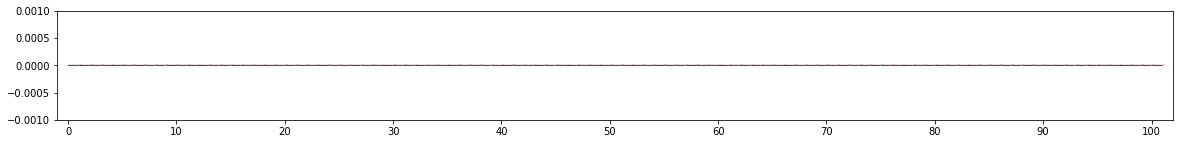

In [194]:
%matplotlib inline
from deeplift.visualization import viz_sequence

idx_view = 62
print("Preceding 10 bases: " + seq_df.sequence[idx_view][47:50])
print("Preceding 10 bases: " + seq_df.sequence[idx_view][51:54])
print("Edit rate: " + str(seq_df.rate[idx_view]))


scores_for_idx = scores[idx_view]
print(sum(scores_for_idx))
original_onehot = onehot_data_noedit[idx_view]
scores_for_idx = original_onehot*scores_for_idx[:,None]
viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10)